This notebook will write a class that performs PCA and HMM on macro indicators (maybe will have two classes, one for PCA and one for HMM)

In [15]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [5]:
class MacroPCA:
    def __init__(self, data, n_components = None):
        """
        Initialse the PCA wrapper.
        param: data - dataframe of macroeconomic indicators
        param: n_components - number of principal components to keep (default: all)
        """
        self.data = data
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)
        self.fitted = False

    def standardise(self):
        self.data_scaled = self.scaler.fit_transform(self.data)
        return self.data_scaled
    
    def run_pca(self):
        if not hasattr(self, 'data_scaled'):
            raise ValueError("You must call standardize() before run_pca().")
        
        self.components = self.pca.fit_transform(self.data_scaled)
        self.explained_variance = self.pca.explained_variance_ratio_
        self.loadings = pd.DataFrame(self.pca.components_.T,
                                     index=self.data.columns,
                                     columns=[f'PC{i+1}' for i in range(self.pca.n_components_)])
        self.fitted = True
        return pd.DataFrame(self.components,
                             columns=self.loadings.columns,
                             index=self.data.index)
        
    def get_explained_variance(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.explained_variance

    def get_loadings(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.loadings




In [6]:
# Get the macro data
macro_df = pd.read_csv("monthly_macro.csv")
macro_df.set_index('Date', inplace=True)
macro_df = macro_df[macro_df.index >= '1990-01-01']


In [7]:
model = MacroPCA(data=macro_df, n_components=4)
model.standardise()
pc_df = model.run_pca()

# Optional:
print(model.get_explained_variance())
print(model.get_loadings())


[0.44346413 0.18114306 0.13684418 0.09245506]
                       PC1       PC2       PC3       PC4
VIX              -0.177389  0.535876 -0.244452  0.448400
2Y                0.458181  0.280575  0.140574  0.008471
10Y               0.370743  0.344026  0.430815 -0.017367
YieldCurve       -0.351235  0.033261  0.565788 -0.057706
CreditSpread     -0.400851  0.304392 -0.115394  0.204326
FedFundsRate      0.459148  0.270138  0.026473  0.026666
Inflation_YoY     0.143042 -0.339343  0.207414  0.867295
UnemploymentRate -0.307593  0.179755  0.571097 -0.019255
GDP_YoY           0.105900 -0.448954  0.177692  0.014249


Ideas for interpretations:
PC1 - Tight monetary conditions/poliy regime. 
PC2 - Risk Sentiment/Financial Stress
PC3 - Yield Curve Steepness + Labur Slack
PC4 - Inflation specific component

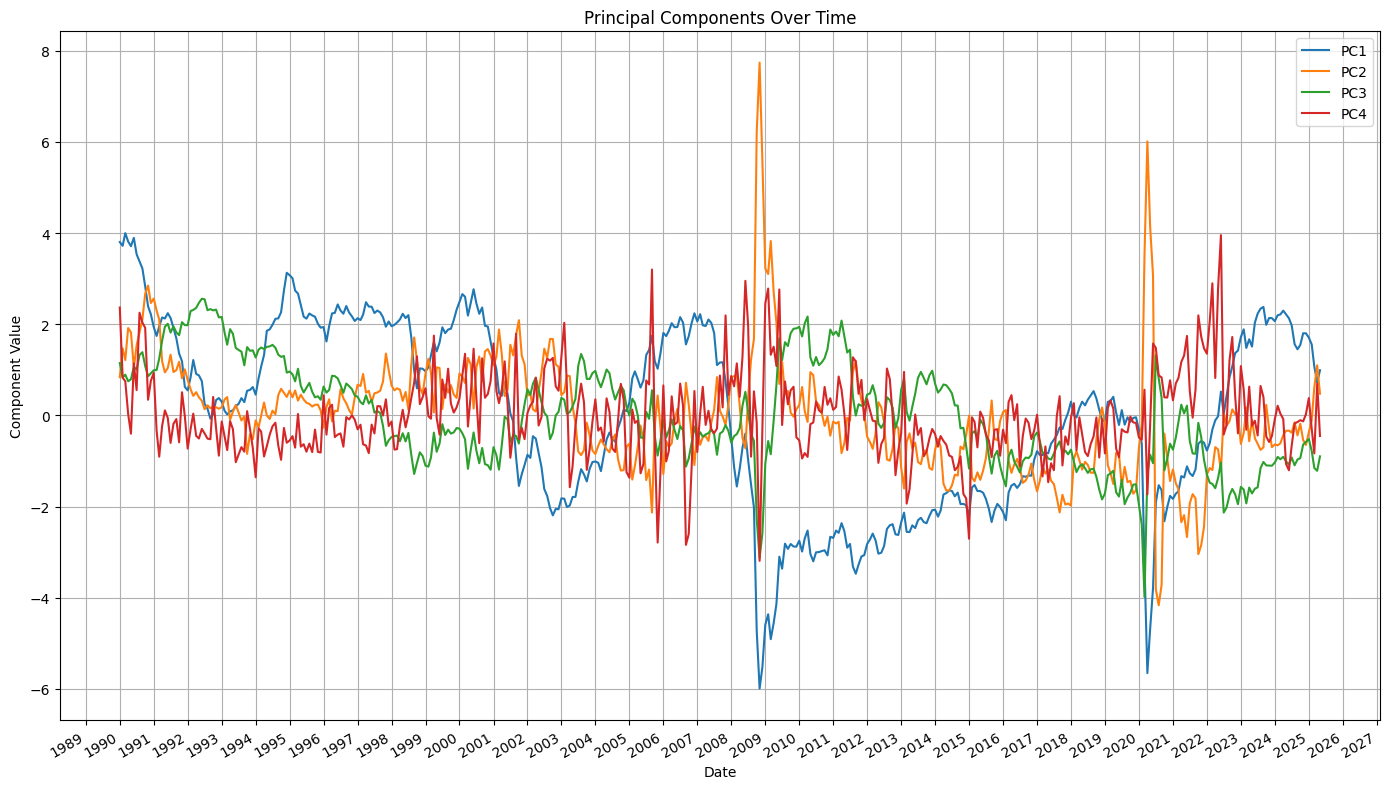

In [18]:
pc_df.index = pd.to_datetime(pc_df.index)

plt.figure(figsize=(14,8))
for i in range(4):
    plt.plot(pc_df.index, pc_df.iloc[:,i], label=f'PC{i+1}')
plt.title('Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Component Value')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for readability

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from hmmlearn.hmm import GaussianHMM


In [ ]:
# Use top N principal components
n_regimes = 3  # Assumes there are three latent macro regimes. Assumption based on economic intuition (e.g., expansion, contraction, and transition), but can be varied.

# covariance_type='full' allows each regime to have its own full covariance matrix, capturing correlations among the PCs.


hmm_model = GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=1000, random_state=42)



# Fit the model on the PCA output
hmm_model.fit(pc_df)

# Predict regime labels
regime_labels = hmm_model.predict(pc_df)

# Add regime labels to your DataFrame
pc_df['Regime'] = regime_labels

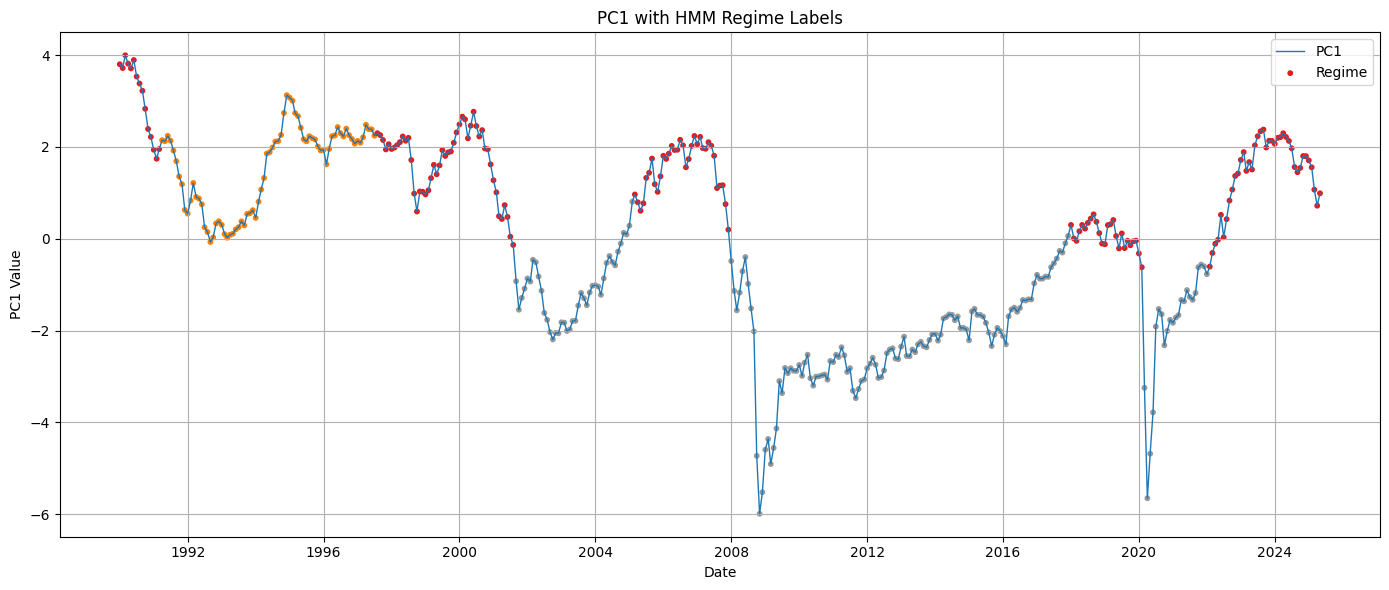

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pc_df.index, pc_df['PC1'], label='PC1', linewidth=1)

# plt.plot(pc_df.index, pc_df['PC2'], label='PC2', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC3'], label='PC3', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC4'], label='PC4', linewidth=1)

plt.scatter(pc_df.index, pc_df['PC1'], c=pc_df['Regime'], cmap='Set1', label='Regime', s=10)
plt.title('PC1 with HMM Regime Labels')
plt.xlabel('Date')
plt.ylabel('PC1 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
print("HMM Transition Matrix:")
print(np.round(hmm_model.transmat_, 3))


HMM Transition Matrix:
[[0.976 0.006 0.018]
 [0.013 0.987 0.   ]
 [0.016 0.    0.984]]


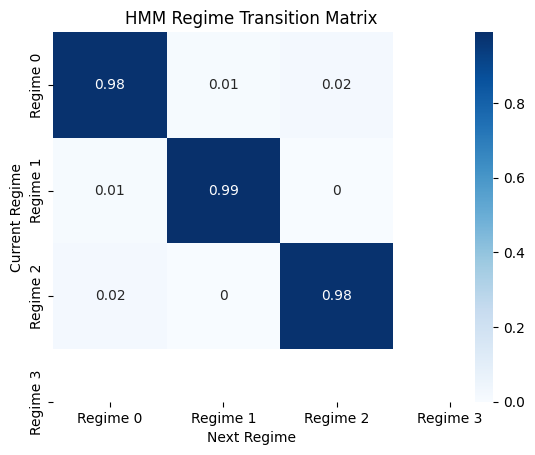

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.heatmap(np.round(hmm_model.transmat_, 2), annot=True, cmap="Blues",
            xticklabels=[f'Regime {i}' for i in range(model.n_components)],
            yticklabels=[f'Regime {i}' for i in range(model.n_components)])
plt.title("HMM Regime Transition Matrix")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()
